## Imports

In [1]:
from pathlib import Path
import sys

# Add repo root and code/ to sys.path
repo_root = Path.cwd().parents[1]
sys.path.insert(0, str(repo_root))
sys.path.insert(0, str(repo_root / "code"))

from utils import helper_functions as hf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from skimage.registration import phase_cross_correlation
import os
import importlib
import torch
import torch.nn.functional as F
from scipy import signal
import cv2
from IPython import get_ipython
from IPython.display import display
import matplotlib
from matplotlib.colors import TwoSlopeNorm
from matplotlib.patches import Rectangle
from matplotlib import animation


---
### load subjects and plot raw fUS activity of their first session over time with label shading (blue = baseline)

In [2]:
hf = importlib.reload(hf)

subjects = ["secundo", "gus"]

repo_root = Path(r"C:\Users\ESPCI\Documents\GitHub\fUSPredict")
source_root = repo_root / "sourcedata"
deriv_root = repo_root / "derivatives" / "preprocessing"

# for subject in subjects:
#     data_directory = source_root / subject
#     data_output_dir = deriv_root / subject  # subject-specific output folder
#     data_output_dir.mkdir(parents=True, exist_ok=True)

#     print(f"Subject: {subject}")
#     print(f"  data_directory: {data_directory}")
#     print(f"  data_output_dir: {data_output_dir}")

#     hf.plot_fus_timecourse_with_labels(
#         str(data_directory),
#         sessions="first"
#     )


---
### Load Baseline Data

Load baseline sessions for model training.

In [3]:
DATA_MODE = "mean_divide"   # "raw" | "mean_divide" | "zscore"

def load_saved_baseline_sessions(base_dir):
    sessions = []
    for p in sorted(Path(base_dir).glob("baseline_*.npz")):
        try:
            d = np.load(p, allow_pickle=False)
            sess = {
                "frames": d["frames"].astype(np.float32, copy=False),
                "session_id": str(d["session_id"]),
                "original_indices": d["original_indices"] if "original_indices" in d.files else None,
                "metadata": {k: d[k] for k in d.files if k not in ["frames", "session_id", "original_indices"]},
            }
            sessions.append(sess)
        except Exception as e:
            print(f"Ã¢ÂÅ’ Error loading {p.name}: {e}")
    print(f"Ã¢Å“â€¦ Loaded {len(sessions)} baseline sessions")
    return sessions

def get_baseline_dir(deriv_root, subject, mode):
    if mode == "raw":
        return Path(deriv_root) / subject / "baseline_only"
    return Path(deriv_root) / subject / "baseline_only_normalized" / mode


In [4]:
for subject in subjects:
    data_directory = source_root / subject
    data_output_dir = deriv_root / subject  # subject-specific output folder
    data_output_dir.mkdir(parents=True, exist_ok=True)
    if DATA_MODE == "raw":
        baseline_output_dir = os.path.join(data_output_dir, "baseline_only")
    else:
        baseline_output_dir = os.path.join(data_output_dir, f"baseline_only_normalized/{DATA_MODE}")
    # Load all baseline sessions
    baseline_sessions = load_saved_baseline_sessions(baseline_output_dir)

    # Print summary
    if len(baseline_sessions) > 0:
        print(f"\nBaseline Data Summary:{subject} ({DATA_MODE})")
        print(f"  Total sessions: {len(baseline_sessions)}")
        total_frames = sum(s['frames'].shape[0] for s in baseline_sessions)
        print(f"  Total baseline frames: {total_frames:,}")
        
        spatial_shapes = [s['frames'].shape[1:] for s in baseline_sessions]
        unique_shapes = set(spatial_shapes)
        print(f"  Spatial dimensions: {unique_shapes}")
        
        # Show frame count distribution
        frame_counts = [s['frames'].shape[0] for s in baseline_sessions]
        print(f"  Frames per session: min={min(frame_counts)}, max={max(frame_counts)}, "
            f"mean={np.mean(frame_counts):.0f}, std={np.std(frame_counts):.0f}")
        
        # first session
        if len(baseline_sessions) > 0:
            first_session = baseline_sessions[0]
            print(f"\n  First session ({first_session['session_id']}):")
            print(f"    Frames: {first_session['frames'].shape[0]}")
            print(f"    Shape: {first_session['frames'].shape}")
            print(f"    Dtype: {first_session['frames'].dtype}")
            print(f"    Value range: [{first_session['frames'].min():.2f}, {first_session['frames'].max():.2f}]")

Ã¢Å“â€¦ Loaded 34 baseline sessions

Baseline Data Summary:secundo (mean_divide)
  Total sessions: 34
  Total baseline frames: 14,043
  Spatial dimensions: {(128, 107), (128, 91), (128, 132), (128, 122), (128, 112), (128, 96), (128, 101)}
  Frames per session: min=1, max=906, mean=413, std=202

  First session (Se01072020):
    Frames: 526
    Shape: (526, 128, 101)
    Dtype: float32
    Value range: [-0.84, 3.03]
Ã¢Å“â€¦ Loaded 13 baseline sessions

Baseline Data Summary:gus (mean_divide)
  Total sessions: 13
  Total baseline frames: 5,838
  Spatial dimensions: {(128, 81), (128, 132), (128, 122), (128, 112), (128, 96), (128, 101)}
  Frames per session: min=258, max=549, mean=449, std=123

  First session (Gu03092020):
    Frames: 539
    Shape: (539, 128, 112)
    Dtype: float32
    Value range: [-0.87, 4.50]


---
## Exploratory data analysis

---

### 1. Visualize individual pixels
 the first cell displays a sample frame in which you can move your mouse over to get the pixel coordinates.
 You can then plug the coordinates into the second cell to display the time course of that individual pixel (mean subtracted baseline)

 this is the frame 0 at y = 49 x = 21. it is different form the colour of the patch plot which is supposed to be frame 0 at y = 49 x = 21 at the centre with the surrounding pixels. why arent they the same colours?

 #### section setup

In [5]:
USE_WIDGET = True  # set False to force static inline plot

ipy = get_ipython()
backend_mode = "inline"

if ipy is not None and USE_WIDGET:
    try:
        ipy.run_line_magic('matplotlib', 'widget')
        backend_mode = "widget"
    except Exception as e:
        print(f"Could not enable interactive matplotlib backend ({e}); falling back to inline.")
        try:
            ipy.run_line_magic('matplotlib', 'inline')
        except Exception:
            pass
else:
    if ipy is not None:
        try:
            ipy.run_line_magic('matplotlib', 'inline')
        except Exception:
            pass

print(f"Matplotlib backend: {matplotlib.get_backend()} | mode={backend_mode}")

subjects = ["secundo", "gus"]
sample_subject = subjects[0]  # change if needed
sample_session_idx = 2        # change if needed
sample_frame_idx = 0          # change if needed

baseline_output_dir = (deriv_root / sample_subject / "baseline_only")
baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))


Matplotlib backend: widget | mode=widget
✅ Loaded 34 baseline sessions


#### load normalized baseline frames

In [6]:
if len(baseline_sessions) == 0:
    raise RuntimeError(f"No baseline sessions found for {sample_subject}")

sample_session = baseline_sessions[sample_session_idx]
raw_frames = sample_session["frames"].astype(np.float32, copy=False)
mean_frames = hf.normalize_frames_pixelwise(raw_frames, method="mean_divide")

if not (0 <= sample_frame_idx < mean_frames.shape[0]):
    raise ValueError(f"sample_frame_idx={sample_frame_idx} out of range [0, {mean_frames.shape[0]-1}]")

frame = mean_frames[sample_frame_idx]

#### Sample frame
##### display a sample frame 

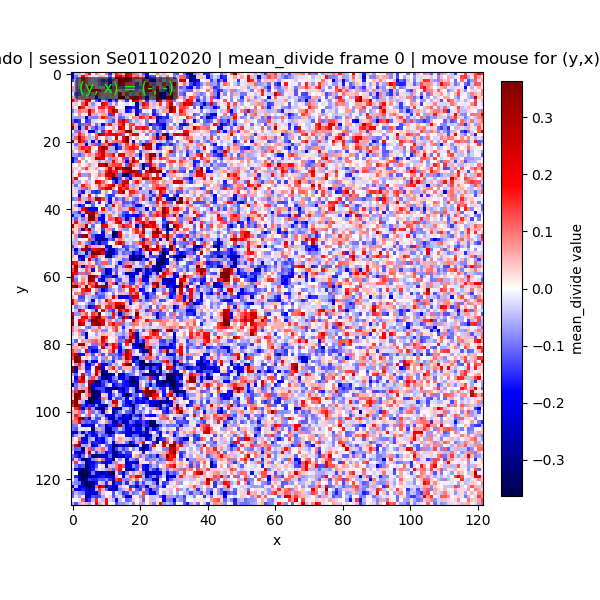

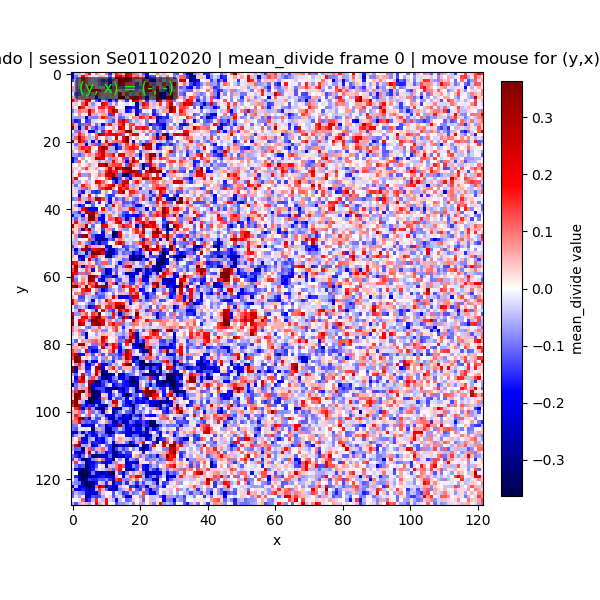

In [7]:
# symmetric limits around 0 for diverging display
abs_lim = float(np.percentile(np.abs(frame), 99.0))
if abs_lim <= 1e-8:
    abs_lim = 1.0
norm = TwoSlopeNorm(vmin=-abs_lim, vcenter=0.0, vmax=abs_lim)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(frame, cmap='seismic', norm=norm)
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('mean_divide value', rotation=90)
ax.set_title(
    f"{sample_subject} | session {sample_session['session_id']} | mean_divide frame {sample_frame_idx} | move mouse for (y,x)"
)
ax.set_xlabel("x")
ax.set_ylabel("y")

coord_text = ax.text(
    0.02, 0.98, "(y, x) = (-, -)",
    transform=ax.transAxes,
    ha='left', va='top',
    fontsize=11,
    color='lime',
    bbox=dict(facecolor='black', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.25')
)


def on_move(event):
    if event.inaxes != ax or event.xdata is None or event.ydata is None:
        return
    x = int(round(event.xdata))
    y = int(round(event.ydata))
    h, w = frame.shape
    if 0 <= x < w and 0 <= y < h:
        coord_text.set_text(f"(y, x) = ({y}, {x})")
        fig.canvas.draw_idle()


# show coordinates in status/toolbar when supported
ax.format_coord = lambda x, y: f"x={int(round(x))}, y={int(round(y))}" if (x is not None and y is not None) else ""

_ = fig.canvas.mpl_connect('motion_notify_event', on_move)
plt.tight_layout()
explorer_fig = fig

# explicit display path for reliability across frontends
if backend_mode == "widget":
    display(fig.canvas)
else:
    display(fig)
    plt.show()

##### create and save whole sampe frame timecourse with red/ blue colour map 

In [8]:
ref_frame = mean_frames[sample_frame_idx]
abs_lim = float(np.percentile(np.abs(ref_frame), 99.0))
if abs_lim <= 1e-8:
    abs_lim = 1.0
norm = TwoSlopeNorm(vmin=-abs_lim, vcenter=0.0, vmax=abs_lim)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(mean_frames[0], cmap="seismic", norm=norm)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("mean_divide value", rotation=90)

title = ax.set_title(
    f"{sample_subject} | session {sample_session['session_id']} | mean_divide frame 0"
)
ax.set_xlabel("x")
ax.set_ylabel("y")

T = mean_frames.shape[0]

def update(i):
    im.set_data(mean_frames[i])
    title.set_text(
        f"{sample_subject} | session {sample_session['session_id']} | mean_divide frame {i}"
    )
    return (im,)

ani = animation.FuncAnimation(fig, update, frames=T, interval=100, blit=False, repeat=False)

out_dir = Path("html_outputs") / "videos"
out_dir.mkdir(parents=True, exist_ok=True)
base = f"{sample_subject}_session-{sample_session['session_id']}_mean_divide"

mp4_path = out_dir / f"{base}.mp4"
gif_path = out_dir / f"{base}.gif"

saved = None
try:
    writer = animation.FFMpegWriter(fps=10, bitrate=1800)
    ani.save(str(mp4_path), writer=writer, dpi=150)
    saved = mp4_path
except FileNotFoundError:
    print("ffmpeg not found; saving GIF instead...")
    writer = animation.PillowWriter(fps=10)
    ani.save(str(gif_path), writer=writer, dpi=120)
    saved = gif_path

plt.close(fig)
print(f"Saved: {saved}")



Saved: html_outputs\videos\secundo_session-Se01102020_mean_divide.mp4


##### display timecourse of a given pixel in a sample frame

✅ Loaded 34 baseline sessions


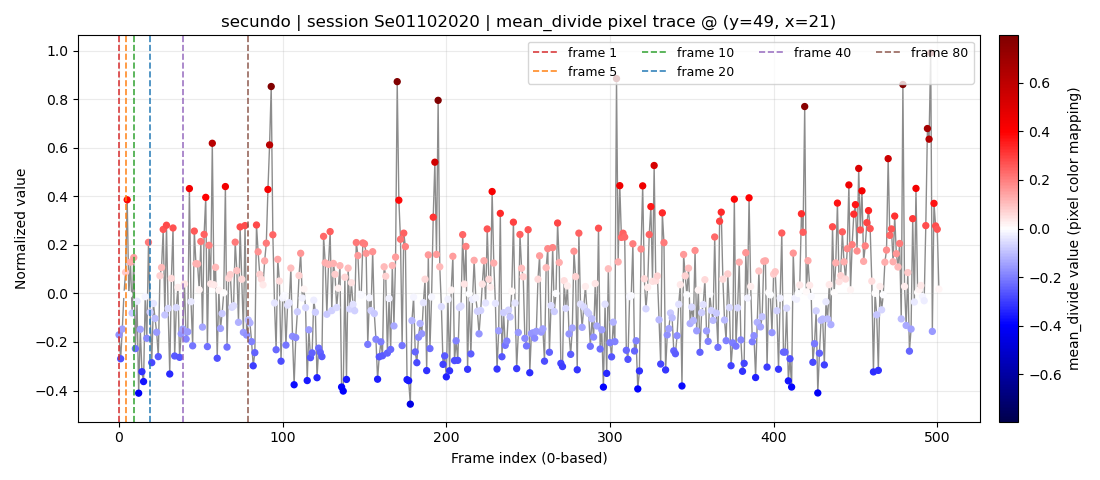

In [9]:
# plot one pixel over time (mean_divide normalization) for a sample baseline acquisition
# with color-mapped values + colorbar

from matplotlib.colors import TwoSlopeNorm

sample_subject = subjects[0]  # change if needed
sample_session_idx = 2        # change if needed

baseline_output_dir = (deriv_root / sample_subject / "baseline_only")
baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

if len(baseline_sessions) == 0:
    raise RuntimeError(f"No baseline sessions found for {sample_subject}")

sample_session = baseline_sessions[sample_session_idx]
raw_frames = sample_session["frames"].astype(np.float32, copy=False)  # (T,H,W)
mean_frames = hf.normalize_frames_pixelwise(raw_frames, method="mean_divide")

T, H, W = mean_frames.shape
y = 49
x = 21  # slightly left of center

pixel_ts = mean_frames[:, y, x]
t = np.arange(T)

# symmetric color limits around 0 from robust percentile of this pixel trace
abs_lim = float(np.percentile(np.abs(pixel_ts), 99.0))
if abs_lim <= 1e-8:
    abs_lim = 1.0
norm = TwoSlopeNorm(vmin=-abs_lim, vcenter=0.0, vmax=abs_lim)

fig, ax = plt.subplots(figsize=(11, 4.8))
ax.plot(t, pixel_ts, color='black', linewidth=1.0, alpha=0.45, zorder=1)
sc = ax.scatter(t, pixel_ts, c=pixel_ts, cmap='seismic', norm=norm, s=18, zorder=2)

marker_frames_1based = [1, 5, 10, 20, 40, 80]
marker_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:purple', 'tab:brown']

for f, c in zip(marker_frames_1based, marker_colors):
    idxf = f - 1  # convert to 0-based index for plotting
    if 0 <= idxf < T:
        ax.axvline(idxf, linestyle='--', linewidth=1.2, color=c, alpha=0.9, label=f'frame {f}')

cbar = fig.colorbar(sc, ax=ax, fraction=0.04, pad=0.02)
cbar.set_label('mean_divide value (pixel color mapping)', rotation=90)

ax.set_title(f"{sample_subject} | session {sample_session['session_id']} | mean_divide pixel trace @ (y={y}, x={x})")
ax.set_xlabel("Frame index (0-based)")
ax.set_ylabel("Normalized value")
ax.grid(alpha=0.25)
ax.legend(ncol=4, fontsize=9)
fig.tight_layout()
pixel_trace_fig = fig
plt.show()




#### Smaller sample patch
#####  setup section

In [10]:
# load data + set up for plotting multiple pixels around a given pixel
from matplotlib.colors import TwoSlopeNorm

sample_subject = subjects[0]
sample_session_idx = 2        

baseline_output_dir = (deriv_root / sample_subject / "baseline_only")
baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

if len(baseline_sessions) == 0:
    raise RuntimeError(f"No baseline sessions found for {sample_subject}")

sample_session = baseline_sessions[sample_session_idx]
raw_frames = sample_session["frames"].astype(np.float32, copy=False)  # (T,H,W)
mean_frames = hf.normalize_frames_pixelwise(raw_frames, method="mean_divide")

T, H, W = mean_frames.shape
pixel = (49, 21) 
center_pixel = pixel
radius = 1

y0 = max(0, pixel[0] - radius)
x0 = max(0, pixel[1] - radius)
y1 = min(H, pixel[0] + radius+1)
x1 = min(W, pixel[1] + radius+1)
y_range = range(y0 - pixel[0], y1 - pixel[0])
x_range = range(x0 - pixel[1], x1 - pixel[1])

surrounding_pixels = [(pixel[0] + dy, pixel[1] + dx) for dy in y_range for dx in x_range if (dy, dx) != (0, 0)]

pixel_coordinates = sorted(surrounding_pixels + [pixel])
print(f"Plotting {len(pixel_coordinates)} pixels around (y={pixel[0]}, x={pixel[1]})")
pixel_trace_colours = [f"C{i}" for i in range(len(pixel_coordinates))]
coord_to_color = {p: pixel_trace_colours[i] for i, p in enumerate(pixel_coordinates)}

✅ Loaded 34 baseline sessions
Plotting 9 pixels around (y=49, x=21)


#####  display timecourse of a given pixel within a smaller patch in a sample frame

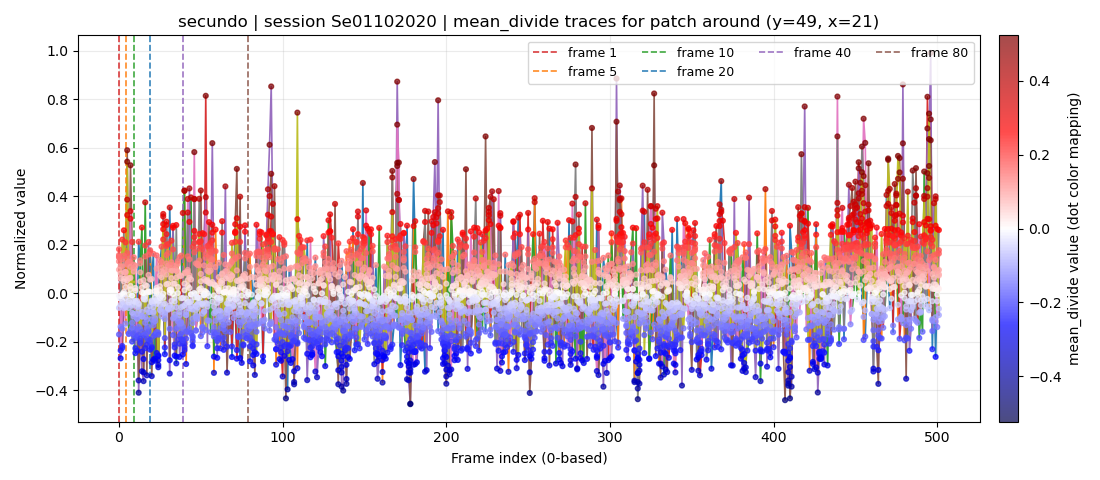

In [11]:
# plot multile pixels over time (mean_divide normalization) for a sample baseline acquisition

all_patch_values = np.concatenate([mean_frames[:, y, x] for (y, x) in pixel_coordinates])
abs_lim = float(np.nanpercentile(np.abs(all_patch_values), 99.0))
if not np.isfinite(abs_lim) or abs_lim <= 1e-8:
    abs_lim = 1.0
norm = TwoSlopeNorm(vmin=-abs_lim, vcenter=0.0, vmax=abs_lim)

fig, ax = plt.subplots(figsize=(11, 4.8))
for pixel in pixel_coordinates:
    y, x = pixel
    pixel_ts = mean_frames[:, y, x]
    t = np.arange(T)

    trace_color = coord_to_color[pixel]
    ax.plot(t, pixel_ts, color=trace_color, linewidth=1.2, alpha=0.95, zorder=2)
    sc = ax.scatter(t, pixel_ts, c=pixel_ts, cmap='seismic', norm=norm, s=12, alpha=0.70, zorder=3)

marker_frames_1based = [1, 5, 10, 20, 40, 80]
marker_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:purple', 'tab:brown']

for f, c in zip(marker_frames_1based, marker_colors):
    idxf = f - 1  # convert to 0-based index for plotting
    if 0 <= idxf < T:
        ax.axvline(idxf, linestyle='--', linewidth=1.2, color=c, alpha=0.9, label=f'frame {f}')

cbar = fig.colorbar(sc, ax=ax, fraction=0.04, pad=0.02)
cbar.set_label('mean_divide value (dot color mapping)', rotation=90)

ax.set_title(f"{sample_subject} | session {sample_session['session_id']} | mean_divide traces for patch around (y={center_pixel[0]}, x={center_pixel[1]})")
ax.set_xlabel("Frame index (0-based)")
ax.set_ylabel("Normalized value")
ax.grid(alpha=0.25)
ax.legend(ncol=4, fontsize=9)
fig.tight_layout()
# pixel_trace_fig = fig
plt.show()

#####  display a smaller patch of a sample frame 

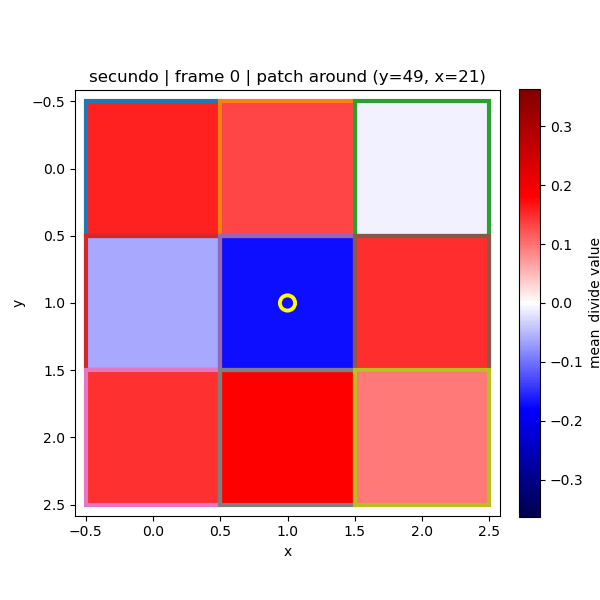

In [12]:
# center pixel as (y, x)
center_pixel = (49, 21)
cy, cx = center_pixel
r = 1  # 3x3 patch
sample_frame_idx=0
frame = mean_frames[sample_frame_idx]  
H, W = frame.shape

# patch bounds
y0, y1 = max(0, cy - r), min(H, cy + r + 1)
x0, x1 = max(0, cx - r), min(W, cx + r + 1)
patch = frame[y0:y1, x0:x1]
h, w = patch.shape

abs_lim = float(np.nanpercentile(np.abs(frame), 99.0))
if not np.isfinite(abs_lim) or abs_lim <= 1e-8:
    abs_lim = 1.0
norm = TwoSlopeNorm(vmin=-abs_lim, vcenter=0.0, vmax=abs_lim)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(patch, cmap="seismic", norm=norm, interpolation="nearest")
pad = 0.08  # small axis buffer so outer borders are visible
ax.set_xlim(-0.5 - pad, w - 0.5 + pad)
ax.set_ylim(h - 0.5 + pad, -0.5 - pad) 

# thicker per-pixel outlines, colored to match trace colors
for iy in range(h):
    for ix in range(w):
        global_coord = (y0 + iy, x0 + ix)  # (y, x) in full frame
        edge = coord_to_color.get(global_coord, "white")
        ax.add_patch(Rectangle((ix - 0.5, iy - 0.5), 1, 1,
                               fill=False, edgecolor=edge, linewidth=3.0))

ax.scatter(cx - x0, cy - y0, s=120, facecolors="none",
           edgecolors="yellow", linewidths=2.8, zorder=5)

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("mean_divide value", rotation=90)

ax.set_title(f"{sample_subject} | frame {sample_frame_idx} | patch around (y={cy}, x={cx})")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal")
plt.show()



##### create and save video of patch time course with red/blue colour map


In [13]:
# center pixel as (y, x)
center_pixel = (49, 21)
cy, cx = center_pixel
r = 1  # 3x3 patch

# patch bounds
y0, y1 = max(0, cy - r), min(H, cy + r + 1)
x0, x1 = max(0, cx - r), min(W, cx + r + 1)
patch = frame[y0:y1, x0:x1]
h, w = patch.shape

patched_frames = mean_frames[:, y0:y1, x0:x1]  # (T, h, w)

sample_frame_idx=0
frame = mean_frames[sample_frame_idx]  
H, W = frame.shape

ref_frame = mean_frames[sample_frame_idx]
abs_lim = float(np.percentile(np.abs(ref_frame), 99.0))
if abs_lim <= 1e-8:
    abs_lim = 1.0
norm = TwoSlopeNorm(vmin=-abs_lim, vcenter=0.0, vmax=abs_lim)



fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(patch, cmap="seismic", norm=norm)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("mean_divide value", rotation=90)

title = ax.set_title(
    f"{sample_subject} | session {sample_session['session_id']} |patch | mean_divide frame 0"
)
ax.set_xlabel("x")
ax.set_ylabel("y")

T = patched_frames.shape[0]

def update(i):
    im.set_data(patched_frames[i])
    title.set_text(
        f"{sample_subject} | session {sample_session['session_id']} | mean_divide frame {i}"
    )
    return (im,)

ani = animation.FuncAnimation(fig, update, frames=T, interval=100, blit=False, repeat=False)

out_dir = Path("html_outputs") / "videos"
out_dir.mkdir(parents=True, exist_ok=True)
base = f"{sample_subject}_session-{sample_session['session_id']}_mean_divide_patch"

mp4_path = out_dir / f"{base}.mp4"
gif_path = out_dir / f"{base}.gif"

saved = None
try:
    writer = animation.FFMpegWriter(fps=10, bitrate=1800)
    ani.save(str(mp4_path), writer=writer, dpi=150)
    saved = mp4_path
except FileNotFoundError:
    print("ffmpeg not found; saving GIF instead...")
    writer = animation.PillowWriter(fps=10)
    ani.save(str(gif_path), writer=writer, dpi=120)
    saved = gif_path

plt.close(fig)
print(f"Saved: {saved}")

Saved: html_outputs\videos\secundo_session-Se01102020_mean_divide_patch.mp4


### 1. Distributions
will display just a sample acquisition, but will save plots for each acquisition
#### Histograms of intensities
per acquisiton 

In [14]:
sample_subject = subjects[0]
sample_session_idx = 2

DIST_N_BINS = 120
DIST_MAX_POINTS = 500_000  # random subsample for speed in histogram ops
DIST_MODE_ORDER = ["mean_divide", "zscore"]
DIST_MODE_RANGES = {
    # "raw": None,                # computed per subject from robust percentiles
    "mean_divide": (-0.25, 0.25),
    "zscore": (-3.0, 3.0),
}

EDA_ROOT_NAME = "eda"


✅ Loaded 34 baseline sessions

[secundo] per-acquisition histograms | sessions=34


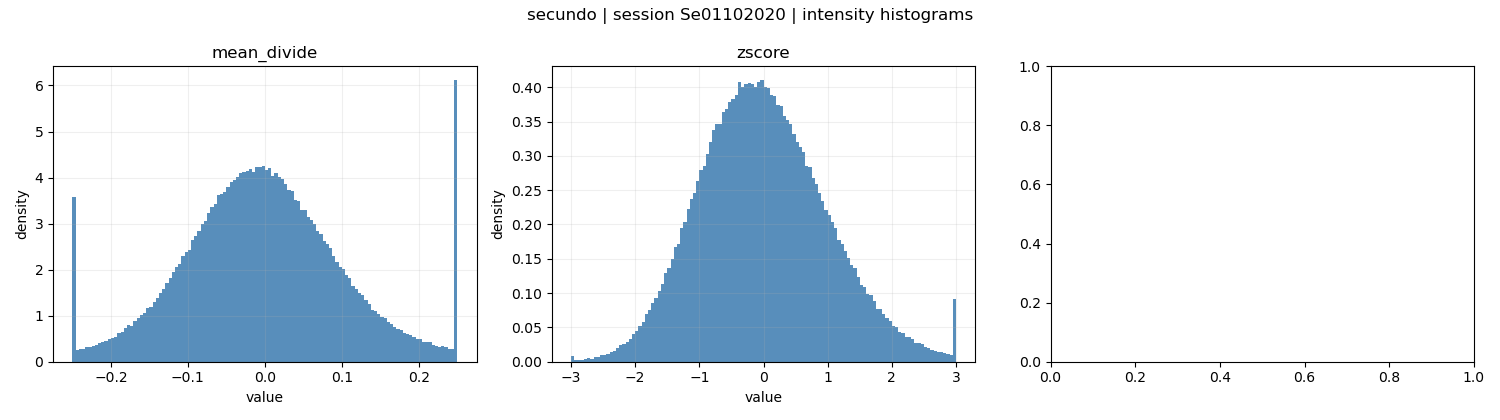

Saved per-acquisition histograms to: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\eda\distribution\hist_per_acquisition
✅ Loaded 13 baseline sessions

[gus] per-acquisition histograms | sessions=13
Saved per-acquisition histograms to: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus\eda\distribution\hist_per_acquisition


In [15]:


def _eda_subject_root(subject):
    root = deriv_root / subject / EDA_ROOT_NAME / "distribution"
    root.mkdir(parents=True, exist_ok=True)
    return root


def _mode_transform(frames, mode):
    if mode == "raw":
        return frames.astype(np.float32, copy=False)
    return hf.normalize_frames_pixelwise(frames, method=mode)


def _flatten_for_hist(arr, max_points=DIST_MAX_POINTS, seed=42):
    v = arr.reshape(-1)
    n = v.size
    if n <= max_points:
        return v
    rng = np.random.default_rng(seed)
    idx = rng.choice(n, size=max_points, replace=False)
    return v[idx]


def _subject_raw_range(baseline_sessions, q_low=1.0, q_high=99.0):
    lows, highs = [], []
    for sess in baseline_sessions:
        f = sess["frames"].astype(np.float32, copy=False)
        lows.append(float(np.percentile(f, q_low)))
        highs.append(float(np.percentile(f, q_high)))
    lo = float(np.median(lows)) if len(lows) else 0.0
    hi = float(np.median(highs)) if len(highs) else 1.0
    if hi <= lo:
        hi = lo + 1e-6
    return lo, hi


for subject in subjects:
    subject_root = _eda_subject_root(subject)
    out_dir = subject_root / "hist_per_acquisition"
    out_dir.mkdir(parents=True, exist_ok=True)

    baseline_output_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

    if len(baseline_sessions) == 0:
        print(f"No baseline sessions for {subject}; skipping per-acquisition histograms")
        continue

    # subject-specific robust range for raw
    raw_lo, raw_hi = _subject_raw_range(baseline_sessions)
    mode_ranges = dict(DIST_MODE_RANGES)
    mode_ranges["raw"] = (raw_lo, raw_hi)

    print(f"\n[{subject}] per-acquisition histograms | sessions={len(baseline_sessions)}")

    for s_idx, sess in enumerate(baseline_sessions):
        session_id = sess["session_id"]
        raw = sess["frames"].astype(np.float32, copy=False)

        fig, axes = plt.subplots(1, 3, figsize=(15, 4.2))

        for ax, mode in zip(axes, DIST_MODE_ORDER):
            arr = _mode_transform(raw, mode)
            vals = _flatten_for_hist(arr, max_points=DIST_MAX_POINTS, seed=42 + s_idx)

            lo, hi = mode_ranges[mode]
            vals_plot = np.clip(vals, lo, hi)

            ax.hist(vals_plot, bins=DIST_N_BINS, range=(lo, hi), density=True, alpha=0.9, color="steelblue")
            ax.set_title(mode)
            ax.set_xlabel("value")
            ax.set_ylabel("density")
            ax.grid(alpha=0.2)

        fig.suptitle(f"{subject} | session {session_id} | intensity histograms")
        fig.tight_layout()

        out_path = out_dir / f"{subject}_{session_id}_hist_triplet.png"
        fig.savefig(out_path, dpi=180)

        if subject == sample_subject and s_idx == sample_session_idx:
            plt.show()
        else:
            plt.close(fig)

    print(f"Saved per-acquisition histograms to: {out_dir}")


#### mean/median/max intensity values over time
per acquisition

✅ Loaded 34 baseline sessions

[secundo] per-acquisition robust framewise stats | sessions=34


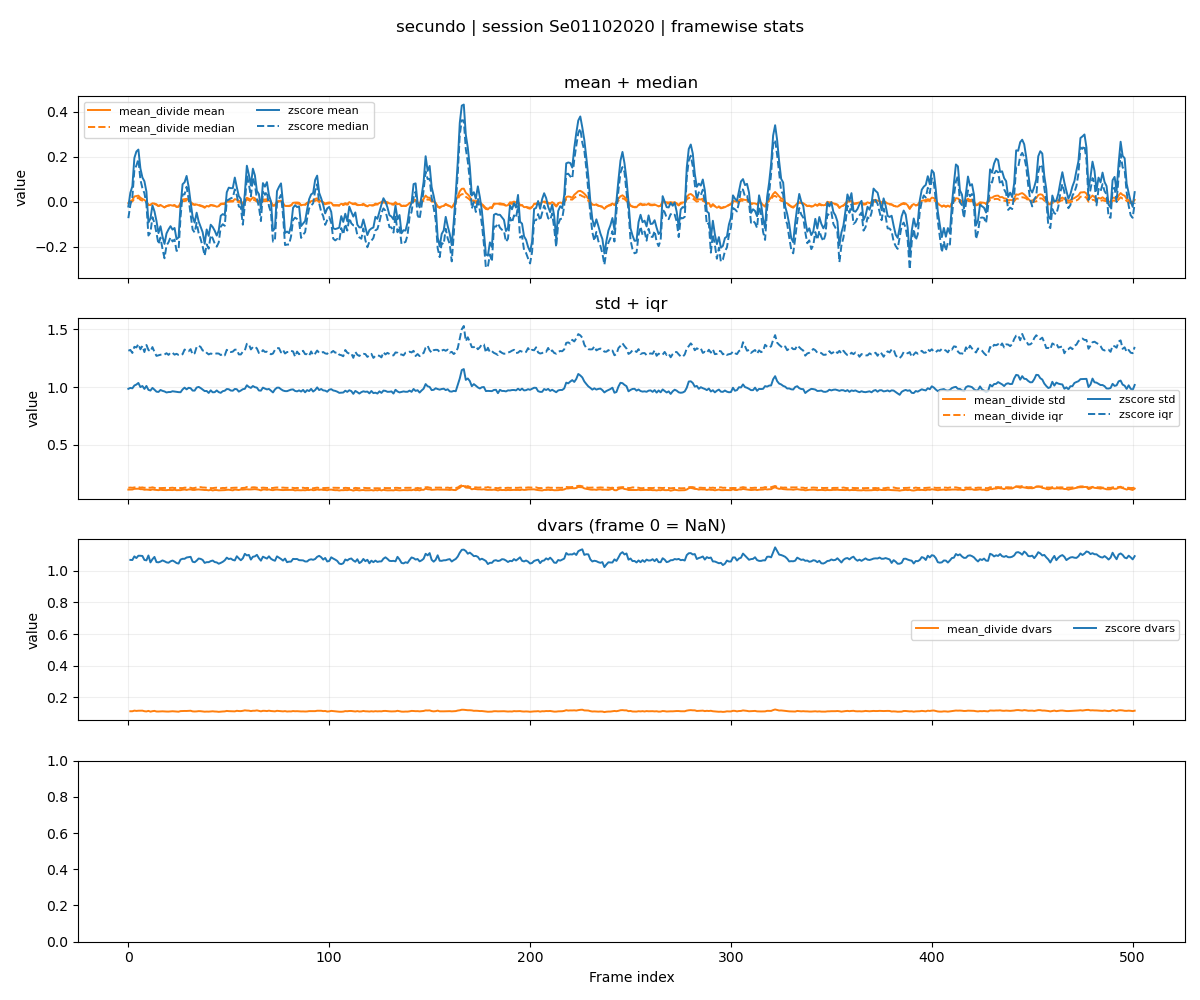

Saved per-acquisition time stats to: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\eda\distribution\time_stats_per_acquisition
✅ Loaded 13 baseline sessions

[gus] per-acquisition robust framewise stats | sessions=13
Saved per-acquisition time stats to: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus\eda\distribution\time_stats_per_acquisition


In [16]:
def _npz_scalar_to_str(value):
    arr = np.asarray(value)
    if arr.ndim == 0:
        item = arr.item()
        if isinstance(item, (bytes, bytearray)):
            return item.decode("utf-8")
        return str(item)
    return str(arr.tolist())


def _squeeze_frames(frames):
    arr = np.asarray(frames)
    if arr.ndim == 3:
        return arr
    if arr.ndim == 4 and arr.shape[1] == 1:
        return arr[:, 0, :, :]
    raise ValueError(f"Unsupported frame shape: {arr.shape}; expected [T,H,W] or [T,1,H,W]")


def _canonical_session_id(value, known_modes):
    s = str(value)
    if s.startswith("baseline_"):
        s = s[len("baseline_"):]
    for mode in sorted(known_modes, key=len, reverse=True):
        suffix = f"_{mode}"
        if s.endswith(suffix):
            s = s[:-len(suffix)]
            break
    return s


def _parse_session_mode_from_filename(fp, known_modes):
    stem = fp.stem
    if stem.startswith("baseline_"):
        stem = stem[len("baseline_"):]
    for mode in sorted(known_modes, key=len, reverse=True):
        suffix = f"_{mode}"
        if stem.endswith(suffix):
            return stem[:-len(suffix)], mode
    parts = stem.split("_")
    if len(parts) >= 2:
        return "_".join(parts[:-1]), parts[-1]
    return stem, None


def compute_framewise_stats(frames_3d):
    arr = np.asarray(frames_3d, dtype=np.float32)
    flat = arr.reshape(arr.shape[0], -1)

    p25 = np.nanpercentile(flat, 25.0, axis=1)
    p75 = np.nanpercentile(flat, 75.0, axis=1)

    dvars = np.full(flat.shape[0], np.nan, dtype=np.float32)
    if flat.shape[0] > 1:
        dvars[1:] = np.nanmean(np.abs(flat[1:] - flat[:-1]), axis=1)

    return {
        "mean": np.nanmean(flat, axis=1),
        "median": np.nanmedian(flat, axis=1),
        # "p99": np.nanpercentile(flat, 99.0, axis=1),
        # "p99_9": np.nanpercentile(flat, 99.9, axis=1),
        "std": np.nanstd(flat, axis=1),
        "iqr": p75 - p25,
        "dvars": dvars,
    }


TARGET_MODES = ["mean_divide", "zscore"]

for subject in subjects:
    subject_root = _eda_subject_root(subject)
    out_dir = subject_root / "time_stats_per_acquisition"
    out_dir.mkdir(parents=True, exist_ok=True)

    baseline_output_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

    if len(baseline_sessions) == 0:
        print(f"No baseline sessions for {subject}; skipping per-acquisition time stats")
        continue

    normalized_dir = deriv_root / subject / "baseline_only_normalized"
    if not normalized_dir.exists():
        print(f"No normalized baseline directory for {subject}: {normalized_dir}; skipping")
        continue

    # Index normalized files by (session_id, mode)
    norm_index = {}
    for fp in sorted(normalized_dir.rglob("*.npz")):
        try:
            file_session, file_mode = _parse_session_mode_from_filename(fp, TARGET_MODES)

            with np.load(fp, allow_pickle=False) as data:
                meta_session = _npz_scalar_to_str(data["session_id"]) if "session_id" in data.files else file_session
                meta_mode = _npz_scalar_to_str(data["normalization"]) if "normalization" in data.files else None

            session_id = _canonical_session_id(meta_session if meta_session else file_session, TARGET_MODES)
            mode = meta_mode if meta_mode else (fp.parent.name if fp.parent.name in TARGET_MODES else file_mode)

            if mode not in TARGET_MODES:
                print(f"⚠️ Ignoring {fp.name}: unsupported mode '{mode}'")
                continue

            norm_index[(session_id, mode)] = fp
        except Exception as e:
            print(f"⚠️ Could not index normalized file {fp.name}: {e}")

    print(f"\n[{subject}] per-acquisition robust framewise stats | sessions={len(baseline_sessions)}")

    for s_idx, sess in enumerate(baseline_sessions):
        session_id = _canonical_session_id(sess["session_id"], TARGET_MODES)

        stats = {}
        frame_count = None
        missing_modes = []

        for mode in TARGET_MODES:
            fp = norm_index.get((session_id, mode))
            if fp is None:
                missing_modes.append(mode)
                continue

            try:
                with np.load(fp, allow_pickle=False) as data:
                    if "frames" not in data.files:
                        raise KeyError("'frames' is not a file in the archive")
                    arr = _squeeze_frames(data["frames"]).astype(np.float32, copy=False)
            except Exception as e:
                print(f"⚠️ {subject} | session {session_id} | mode {mode}: failed to load ({e})")
                missing_modes.append(mode)
                continue

            if frame_count is None:
                frame_count = arr.shape[0]
            elif arr.shape[0] != frame_count:
                print(
                    f"⚠️ {subject} | session {session_id}: frame count mismatch "
                    f"({frame_count} vs {arr.shape[0]}) across modes; skipping session"
                )
                missing_modes = TARGET_MODES.copy()
                break

            stats[mode] = compute_framewise_stats(arr)

        if missing_modes:
            print(f"⚠️ {subject} | session {session_id}: missing/invalid modes {missing_modes}; skipping")
            continue

        t = np.arange(frame_count)
        colors = {"mean_divide": "tab:orange", "zscore": "tab:blue"}
        linestyles = {
            "mean": "-",
            "median": "--",
            # "p99": "-",
            # "p99_9": "--",
            "std": "-",
            "iqr": "--",
            "dvars": "-",
        }

        panel_defs = [
            ("mean + median", ["mean", "median"]),
            # ("p99 + p99.9", ["p99", "p99_9"]),
            ("std + iqr", ["std", "iqr"]),
            ("dvars (frame 0 = NaN)", ["dvars"]),
        ]

        fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
        for ax, (title, metrics) in zip(axes, panel_defs):
            for mode in TARGET_MODES:
                for metric in metrics:
                    ax.plot(
                        t,
                        stats[mode][metric],
                        color=colors.get(mode, None),
                        linestyle=linestyles[metric],
                        linewidth=1.4,
                        label=f"{mode} {metric}",
                    )
            ax.set_title(title)
            ax.set_ylabel("value")
            ax.grid(alpha=0.2)
            ax.legend(fontsize=8, ncol=2, loc="best")

        axes[-1].set_xlabel("Frame index")
        fig.suptitle(f"{subject} | session {session_id} | framewise stats")
        fig.tight_layout(rect=[0, 0, 1, 0.97])

        out_fig = out_dir / f"{subject}_{session_id}_time_stats_triplet.png"
        fig.savefig(out_fig, dpi=180)

        rows = []
        for mode in TARGET_MODES:
            for i in range(len(t)):
                rows.append({
                    "frame": int(i),
                    "mode": mode,
                    "mean": float(stats[mode]["mean"][i]),
                    "median": float(stats[mode]["median"][i]),
                    # "p99": float(stats[mode]["p99"][i]),
                    # "p99_9": float(stats[mode]["p99_9"][i]),
                    "std": float(stats[mode]["std"][i]),
                    "iqr": float(stats[mode]["iqr"][i]),
                    "dvars": float(stats[mode]["dvars"][i]) if np.isfinite(stats[mode]["dvars"][i]) else np.nan,
                })
        pd.DataFrame(rows).to_csv(out_dir / f"{subject}_{session_id}_time_stats_triplet.csv", index=False)

        if subject == sample_subject and s_idx == sample_session_idx:
            plt.show()
        else:
            plt.close(fig)

    print(f"Saved per-acquisition time stats to: {out_dir}")


### 2. Pixel stability
will display just a sample acquisition, but will save plots for each acquisition
#### Mean map + std map
per acquisition

✅ Loaded 34 baseline sessions
\n[secundo] pixel stability mean/std per acquisition | sessions=34


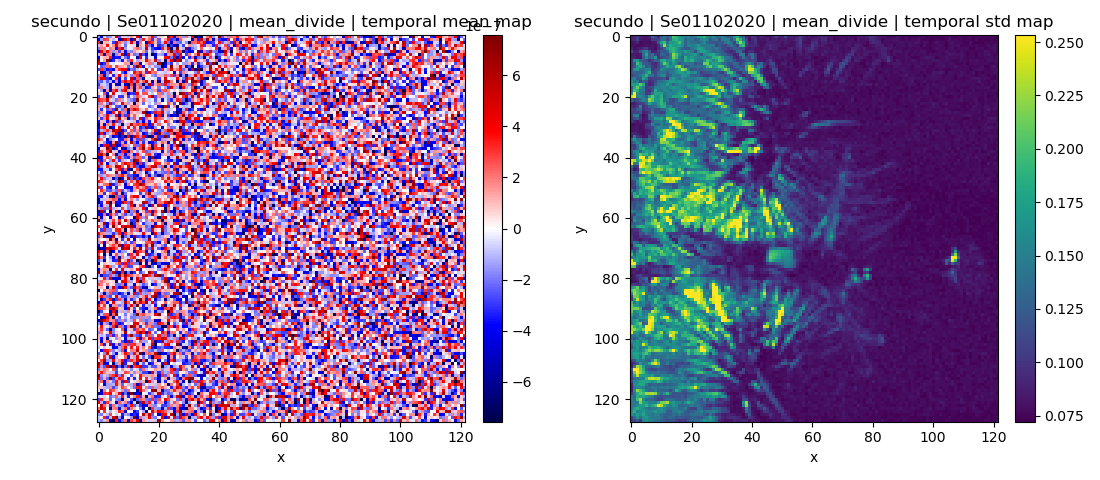

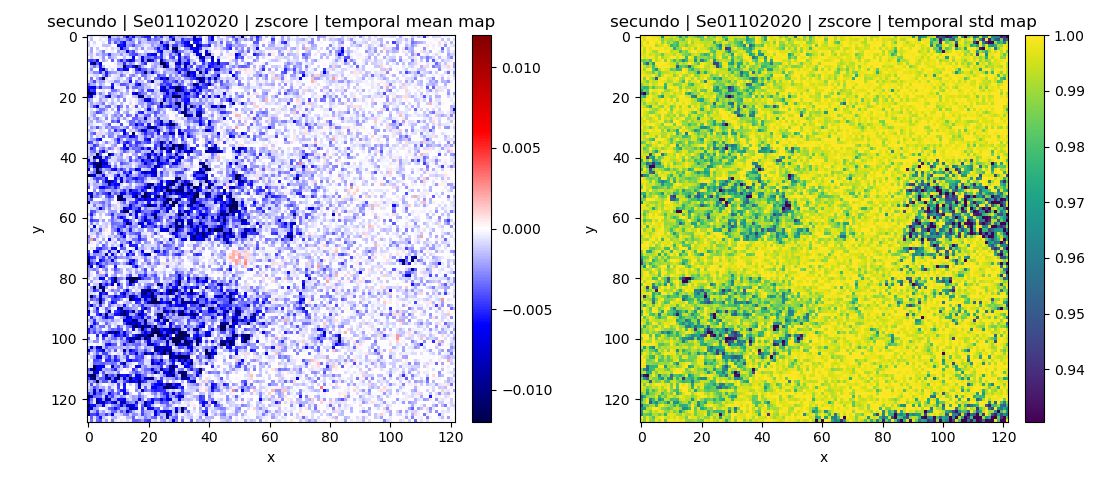

Saved per-acquisition mean/std maps to: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\eda\pixel_stability\mean_std_per_acquisition
✅ Loaded 13 baseline sessions
\n[gus] pixel stability mean/std per acquisition | sessions=13
Saved per-acquisition mean/std maps to: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus\eda\pixel_stability\mean_std_per_acquisition


In [17]:
PIX_MODE_ORDER = list(DIST_MODE_ORDER) if "DIST_MODE_ORDER" in globals() else ["mean_divide", "zscore"]
PIX_EPS = 1e-8
PIX_ROBUST_PCTL = (1.0, 99.0)
PIX_CV_CLIP = 5.0
PIX_ROOT_SUBDIR = "pixel_stability"

def _pix_mode_transform(frames, mode):
    if "_mode_transform" in globals() and callable(_mode_transform):
        return _mode_transform(frames, mode)
    if mode == "raw":
        return frames
    return hf.normalize_frames_pixelwise(frames, method=mode)

def _pix_subject_root(subject):
    return deriv_root / subject / EDA_ROOT_NAME / PIX_ROOT_SUBDIR

def _pix_finite(a):
    return a[np.isfinite(a)]

def _pix_stats(a):
    x = _pix_finite(a)
    if x.size == 0:
        return dict(min=np.nan, max=np.nan, mean=np.nan, median=np.nan)
    return dict(min=float(np.min(x)), max=float(np.max(x)), mean=float(np.mean(x)), median=float(np.median(x)))

def _pix_limits(a, pctl=PIX_ROBUST_PCTL, nonnegative=False, symmetric=False):
    x = _pix_finite(a)
    if x.size == 0:
        return (0.0, 1.0)
    lo, hi = np.percentile(x, pctl)
    lo = float(lo)
    hi = float(hi)
    if symmetric:
        m = max(abs(lo), abs(hi), PIX_EPS)
        return (-m, m)
    if nonnegative:
        lo = max(0.0, lo)
    if hi <= lo + PIX_EPS:
        hi = lo + 1.0
    return (lo, hi)

for subject in subjects:
    baseline_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_dir))
    print(f"\\n[{subject}] pixel stability mean/std per acquisition | sessions={len(baseline_sessions)}")
    if len(baseline_sessions) == 0:
        continue

    out_dir = _pix_subject_root(subject) / "mean_std_per_acquisition"
    out_dir.mkdir(parents=True, exist_ok=True)

    for s_idx, session in enumerate(baseline_sessions):
        session_id = session["session_id"]
        raw = session["frames"].astype(np.float32, copy=False)

        for mode in PIX_MODE_ORDER:
            arr = _pix_mode_transform(raw, mode)
            mu_map = arr.mean(axis=0)
            sd_map = arr.std(axis=0)

            both_signs = (np.nanmin(mu_map) < 0.0) and (np.nanmax(mu_map) > 0.0)
            use_diverging = (mode == "mean_divide") or both_signs
            if use_diverging:
                mu_vmin, mu_vmax = _pix_limits(mu_map, symmetric=True)
                mu_cmap = "seismic"
            else:
                mu_vmin, mu_vmax = _pix_limits(mu_map)
                mu_cmap = "viridis"

            sd_vmin, sd_vmax = _pix_limits(sd_map, nonnegative=True)

            fig, axes = plt.subplots(1, 2, figsize=(11, 4.8))
            im0 = axes[0].imshow(mu_map, cmap=mu_cmap, vmin=mu_vmin, vmax=mu_vmax)
            axes[0].set_title(f"{subject} | {session_id} | {mode} | temporal mean map")
            axes[0].set_xlabel("x")
            axes[0].set_ylabel("y")
            fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

            im1 = axes[1].imshow(sd_map, cmap="viridis", vmin=sd_vmin, vmax=sd_vmax)
            axes[1].set_title(f"{subject} | {session_id} | {mode} | temporal std map")
            axes[1].set_xlabel("x")
            axes[1].set_ylabel("y")
            fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

            fig.tight_layout()
            out_fig = out_dir / f"{subject}_{session_id}_{mode}_mean_std_maps.png"
            fig.savefig(out_fig, dpi=180)

            rows = []
            for map_name, stats in [("mean_map", _pix_stats(mu_map)), ("std_map", _pix_stats(sd_map))]:
                rows.append({
                    "subject": subject,
                    "session_id": session_id,
                    "mode": mode,
                    "map": map_name,
                    "min": stats["min"],
                    "max": stats["max"],
                    "mean": stats["mean"],
                    "median": stats["median"],
                })
            pd.DataFrame(rows).to_csv(
                out_dir / f"{subject}_{session_id}_{mode}_mean_std_maps_summary.csv",
                index=False,
            )

            if subject == sample_subject and s_idx == sample_session_idx:
                plt.show()
            else:
                plt.close(fig)

    print(f"Saved per-acquisition mean/std maps to: {out_dir}")


across acquisitions

✅ Loaded 34 baseline sessions
\n[secundo] pixel stability mean/std across acquisitions | sessions=34
  - skip Se01092020: shape (128, 112) != (128, 101)
  - skip Se01102020: shape (128, 122) != (128, 101)
  - skip Se01122020: shape (128, 122) != (128, 101)
  - skip Se02122020: shape (128, 122) != (128, 101)
  - skip Se03022020: shape (128, 112) != (128, 101)
  - skip Se03092020: shape (128, 112) != (128, 101)
  - skip Se04022020: shape (128, 112) != (128, 101)
  - skip Se04032020: shape (128, 91) != (128, 101)
  - skip Se04082020: shape (128, 112) != (128, 101)
  - skip Se04092020: shape (128, 112) != (128, 101)
  - skip Se05022020: shape (128, 112) != (128, 101)
  - skip Se22092020: shape (128, 122) != (128, 101)
  - skip Se22102019: shape (128, 132) != (128, 101)
  - skip Se22112019: shape (128, 112) != (128, 101)
  - skip Se23072020: shape (128, 96) != (128, 101)
  - skip Se24022020: shape (128, 112) != (128, 101)
  - skip Se25062020: shape (128, 107) != (128, 101)
  - skip Se250820

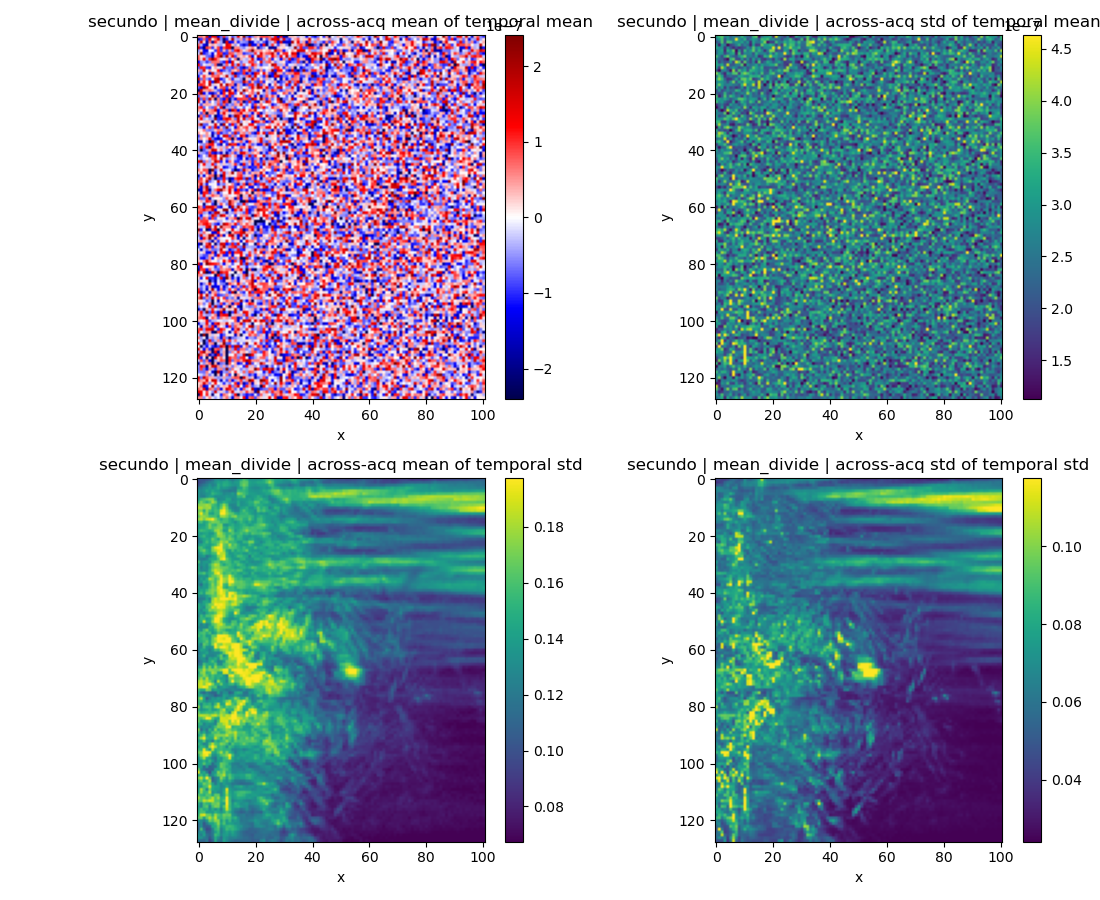

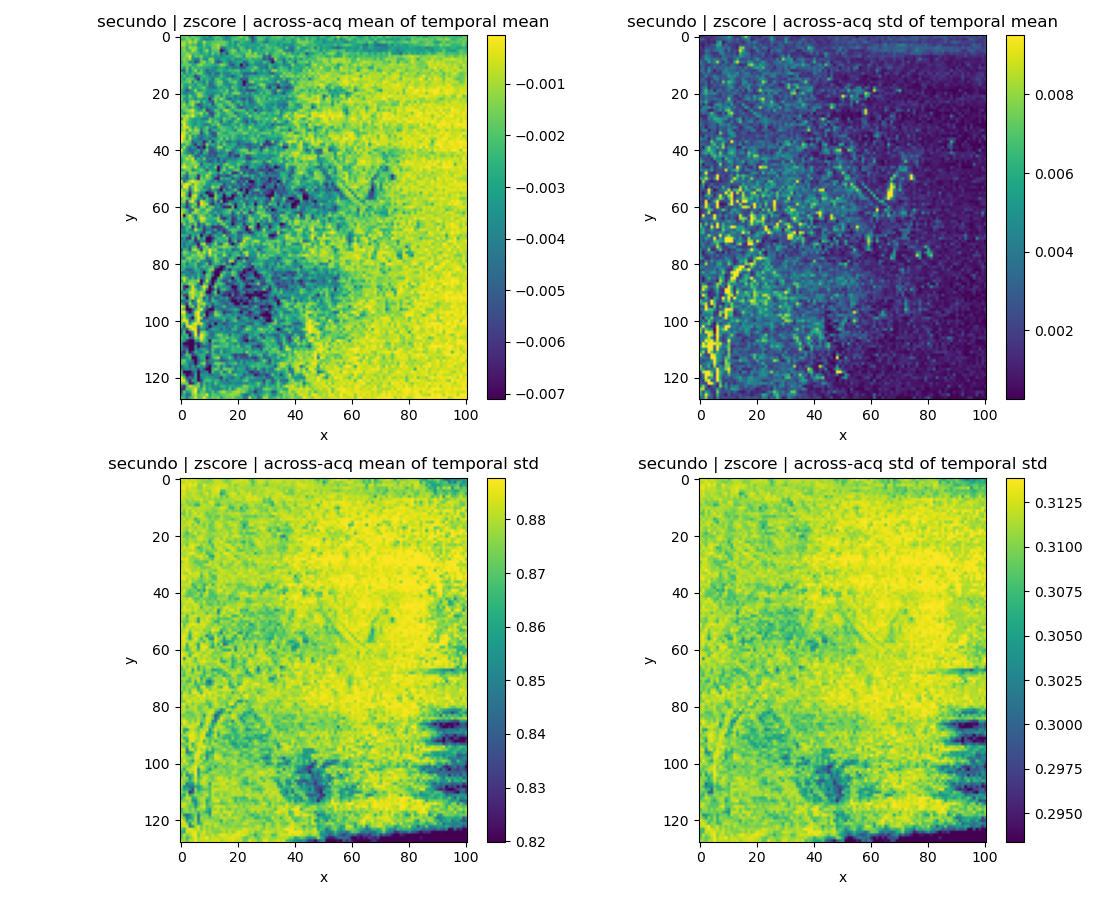

Saved across-acquisition mean/std maps to: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\eda\pixel_stability\mean_std_across_acquisitions
✅ Loaded 13 baseline sessions
\n[gus] pixel stability mean/std across acquisitions | sessions=13
  - skip Gu06102020: shape (128, 81) != (128, 112)
  - skip Gu12042021: shape (128, 101) != (128, 112)
  - skip Gu17092020: shape (128, 96) != (128, 112)
  - skip Gu23072020: shape (128, 122) != (128, 112)
  - skip Gu29032021: shape (128, 132) != (128, 112)
  - skip Gu30032021: shape (128, 101) != (128, 112)
  - skip Gu30042021: shape (128, 101) != (128, 112)
Saved across-acquisition mean/std maps to: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus\eda\pixel_stability\mean_std_across_acquisitions


In [18]:
for subject in subjects:
    baseline_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_dir))
    print(f"\\n[{subject}] pixel stability mean/std across acquisitions | sessions={len(baseline_sessions)}")
    if len(baseline_sessions) == 0:
        continue

    out_dir = _pix_subject_root(subject) / "mean_std_across_acquisitions"
    out_dir.mkdir(parents=True, exist_ok=True)

    mode_collect = {mode: {"mu": [], "sd": []} for mode in PIX_MODE_ORDER}
    ref_shape = None

    for session in baseline_sessions:
        session_id = session["session_id"]
        raw = session["frames"].astype(np.float32, copy=False)
        shp = raw.shape[1:]
        if ref_shape is None:
            ref_shape = shp
        elif shp != ref_shape:
            print(f"  - skip {session_id}: shape {shp} != {ref_shape}")
            continue

        for mode in PIX_MODE_ORDER:
            arr = _pix_mode_transform(raw, mode)
            mode_collect[mode]["mu"].append(arr.mean(axis=0))
            mode_collect[mode]["sd"].append(arr.std(axis=0))

    for mode in PIX_MODE_ORDER:
        if len(mode_collect[mode]["mu"]) == 0:
            print(f"  - skip mode={mode}: no valid sessions")
            continue

        MU = np.stack(mode_collect[mode]["mu"], axis=0)
        SD = np.stack(mode_collect[mode]["sd"], axis=0)

        mu_across_mean = MU.mean(axis=0)
        mu_across_std = MU.std(axis=0)
        sd_across_mean = SD.mean(axis=0)
        sd_across_std = SD.std(axis=0)

        fig, axes = plt.subplots(2, 2, figsize=(11, 9))
        panels = [
            (mu_across_mean, "seismic" if mode == "mean_divide" else "viridis", f"{subject} | {mode} | across-acq mean of temporal mean", False),
            (mu_across_std, "viridis", f"{subject} | {mode} | across-acq std of temporal mean", True),
            (sd_across_mean, "viridis", f"{subject} | {mode} | across-acq mean of temporal std", True),
            (sd_across_std, "viridis", f"{subject} | {mode} | across-acq std of temporal std", True),
        ]

        for ax, (data, cmap, title, nonneg) in zip(axes.ravel(), panels):
            if cmap == "seismic":
                vmin, vmax = _pix_limits(data, symmetric=True)
            else:
                vmin, vmax = _pix_limits(data, nonnegative=nonneg)
            im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
            ax.set_title(title)
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        fig.tight_layout()
        out_fig = out_dir / f"{subject}_{mode}_mean_std_across_acquisitions_maps.png"
        fig.savefig(out_fig, dpi=180)

        rows = []
        for map_name, data in [
            ("mu_across_mean", mu_across_mean),
            ("mu_across_std", mu_across_std),
            ("sd_across_mean", sd_across_mean),
            ("sd_across_std", sd_across_std),
        ]:
            st = _pix_stats(data)
            rows.append({
                "subject": subject,
                "mode": mode,
                "map": map_name,
                "n_sessions": int(MU.shape[0]),
                "min": st["min"],
                "max": st["max"],
                "mean": st["mean"],
                "median": st["median"],
            })
        pd.DataFrame(rows).to_csv(
            out_dir / f"{subject}_{mode}_mean_std_across_acquisitions_summary.csv",
            index=False,
        )

        if subject == sample_subject:
            plt.show()
        else:
            plt.close(fig)

    print(f"Saved across-acquisition mean/std maps to: {out_dir}")


####  CV map
per acquisition

✅ Loaded 34 baseline sessions
\n[secundo] pixel stability CV per acquisition | sessions=34


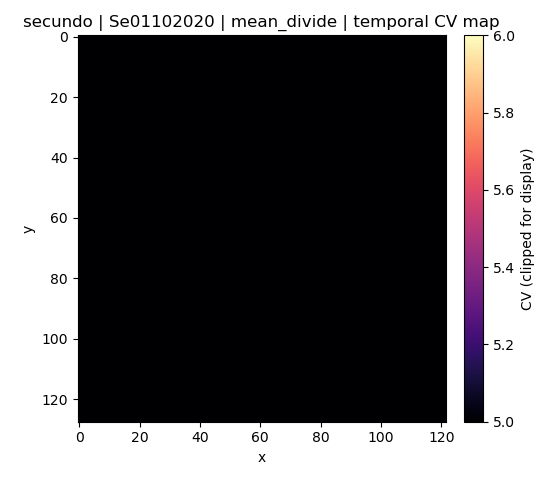

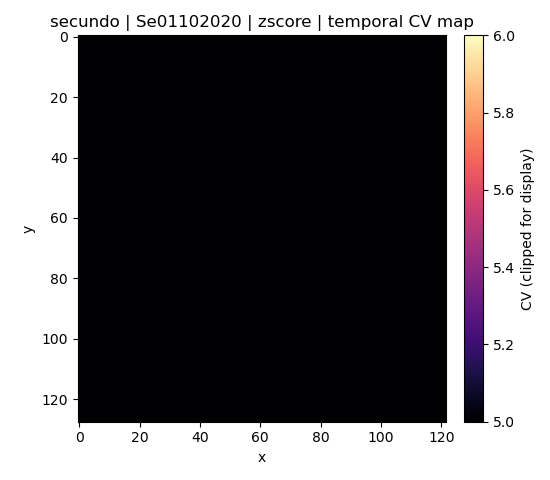

Saved per-acquisition CV maps to: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\eda\pixel_stability\cv_per_acquisition
✅ Loaded 13 baseline sessions
\n[gus] pixel stability CV per acquisition | sessions=13
Saved per-acquisition CV maps to: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus\eda\pixel_stability\cv_per_acquisition


In [19]:
for subject in subjects:
    baseline_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_dir))
    print(f"\\n[{subject}] pixel stability CV per acquisition | sessions={len(baseline_sessions)}")
    if len(baseline_sessions) == 0:
        continue

    out_dir = _pix_subject_root(subject) / "cv_per_acquisition"
    out_dir.mkdir(parents=True, exist_ok=True)

    for s_idx, session in enumerate(baseline_sessions):
        session_id = session["session_id"]
        raw = session["frames"].astype(np.float32, copy=False)

        for mode in PIX_MODE_ORDER:
            arr = _pix_mode_transform(raw, mode)
            mu_map = arr.mean(axis=0)
            sd_map = arr.std(axis=0)
            cv_map = sd_map / (np.abs(mu_map) + PIX_EPS)
            cv_map = np.where(np.isfinite(cv_map), cv_map, np.nan)

            cv_disp = np.clip(cv_map, 0.0, PIX_CV_CLIP)
            cv_vmin, cv_vmax = _pix_limits(cv_disp, nonnegative=True)

            fig, ax = plt.subplots(1, 1, figsize=(5.5, 4.8))
            im = ax.imshow(cv_disp, cmap="magma", vmin=cv_vmin, vmax=cv_vmax)
            ax.set_title(f"{subject} | {session_id} | {mode} | temporal CV map")
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="CV (clipped for display)")
            fig.tight_layout()

            out_fig = out_dir / f"{subject}_{session_id}_{mode}_cv_map.png"
            fig.savefig(out_fig, dpi=180)

            st = _pix_stats(cv_map)
            pd.DataFrame([
                {
                    "subject": subject,
                    "session_id": session_id,
                    "mode": mode,
                    "map": "cv_map",
                    "eps": PIX_EPS,
                    "clip_for_display": PIX_CV_CLIP,
                    "min": st["min"],
                    "max": st["max"],
                    "mean": st["mean"],
                    "median": st["median"],
                }
            ]).to_csv(out_dir / f"{subject}_{session_id}_{mode}_cv_map_summary.csv", index=False)

            if subject == sample_subject and s_idx == sample_session_idx:
                plt.show()
            else:
                plt.close(fig)

    print(f"Saved per-acquisition CV maps to: {out_dir}")


across acquisitions

✅ Loaded 34 baseline sessions
\n[secundo] pixel stability CV across acquisitions | sessions=34
  - skip Se01092020: shape (128, 112) != (128, 101)
  - skip Se01102020: shape (128, 122) != (128, 101)
  - skip Se01122020: shape (128, 122) != (128, 101)
  - skip Se02122020: shape (128, 122) != (128, 101)
  - skip Se03022020: shape (128, 112) != (128, 101)
  - skip Se03092020: shape (128, 112) != (128, 101)
  - skip Se04022020: shape (128, 112) != (128, 101)
  - skip Se04032020: shape (128, 91) != (128, 101)
  - skip Se04082020: shape (128, 112) != (128, 101)
  - skip Se04092020: shape (128, 112) != (128, 101)
  - skip Se05022020: shape (128, 112) != (128, 101)
  - skip Se22092020: shape (128, 122) != (128, 101)
  - skip Se22102019: shape (128, 132) != (128, 101)
  - skip Se22112019: shape (128, 112) != (128, 101)
  - skip Se23072020: shape (128, 96) != (128, 101)
  - skip Se24022020: shape (128, 112) != (128, 101)
  - skip Se25062020: shape (128, 107) != (128, 101)
  - skip Se25082020: sh

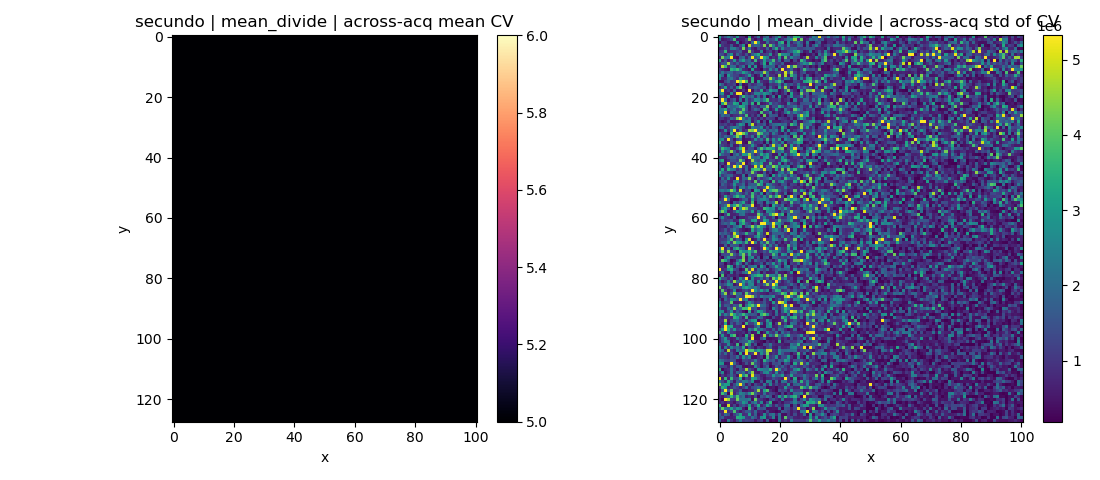

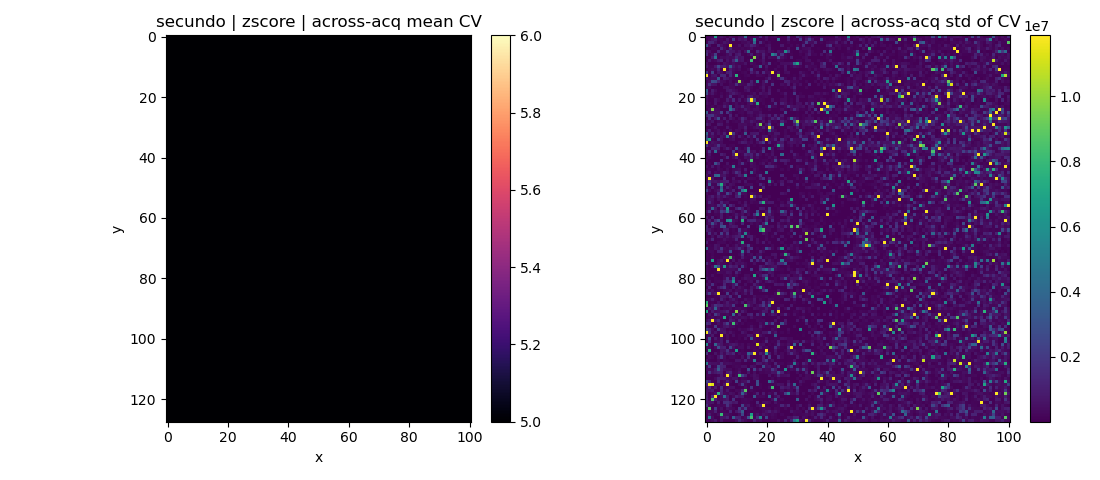

Saved across-acquisition CV maps to: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\eda\pixel_stability\cv_across_acquisitions
✅ Loaded 13 baseline sessions
\n[gus] pixel stability CV across acquisitions | sessions=13
  - skip Gu06102020: shape (128, 81) != (128, 112)
  - skip Gu12042021: shape (128, 101) != (128, 112)
  - skip Gu17092020: shape (128, 96) != (128, 112)
  - skip Gu23072020: shape (128, 122) != (128, 112)
  - skip Gu29032021: shape (128, 132) != (128, 112)
  - skip Gu30032021: shape (128, 101) != (128, 112)
  - skip Gu30042021: shape (128, 101) != (128, 112)
Saved across-acquisition CV maps to: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus\eda\pixel_stability\cv_across_acquisitions


In [20]:
for subject in subjects:
    baseline_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_dir))
    print(f"\\n[{subject}] pixel stability CV across acquisitions | sessions={len(baseline_sessions)}")
    if len(baseline_sessions) == 0:
        continue

    out_dir = _pix_subject_root(subject) / "cv_across_acquisitions"
    out_dir.mkdir(parents=True, exist_ok=True)

    mode_collect = {mode: [] for mode in PIX_MODE_ORDER}
    ref_shape = None

    for session in baseline_sessions:
        session_id = session["session_id"]
        raw = session["frames"].astype(np.float32, copy=False)
        shp = raw.shape[1:]
        if ref_shape is None:
            ref_shape = shp
        elif shp != ref_shape:
            print(f"  - skip {session_id}: shape {shp} != {ref_shape}")
            continue

        for mode in PIX_MODE_ORDER:
            arr = _pix_mode_transform(raw, mode)
            mu_map = arr.mean(axis=0)
            sd_map = arr.std(axis=0)
            cv_map = sd_map / (np.abs(mu_map) + PIX_EPS)
            cv_map = np.where(np.isfinite(cv_map), cv_map, np.nan)
            mode_collect[mode].append(cv_map)

    for mode in PIX_MODE_ORDER:
        if len(mode_collect[mode]) == 0:
            print(f"  - skip mode={mode}: no valid sessions")
            continue

        CV = np.stack(mode_collect[mode], axis=0)
        cv_across_mean = np.nanmean(CV, axis=0)
        cv_across_std = np.nanstd(CV, axis=0)

        mean_disp = np.clip(cv_across_mean, 0.0, PIX_CV_CLIP)
        mean_vmin, mean_vmax = _pix_limits(mean_disp, nonnegative=True)
        std_vmin, std_vmax = _pix_limits(cv_across_std, nonnegative=True)

        fig, axes = plt.subplots(1, 2, figsize=(11, 4.8))
        im0 = axes[0].imshow(mean_disp, cmap="magma", vmin=mean_vmin, vmax=mean_vmax)
        axes[0].set_title(f"{subject} | {mode} | across-acq mean CV")
        axes[0].set_xlabel("x")
        axes[0].set_ylabel("y")
        fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

        im1 = axes[1].imshow(cv_across_std, cmap="viridis", vmin=std_vmin, vmax=std_vmax)
        axes[1].set_title(f"{subject} | {mode} | across-acq std of CV")
        axes[1].set_xlabel("x")
        axes[1].set_ylabel("y")
        fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

        fig.tight_layout()
        out_fig = out_dir / f"{subject}_{mode}_cv_across_acquisitions_maps.png"
        fig.savefig(out_fig, dpi=180)

        rows = []
        for map_name, data in [
            ("cv_across_mean", cv_across_mean),
            ("cv_across_std", cv_across_std),
        ]:
            st = _pix_stats(data)
            rows.append({
                "subject": subject,
                "mode": mode,
                "map": map_name,
                "n_sessions": int(CV.shape[0]),
                "eps": PIX_EPS,
                "clip_for_display": PIX_CV_CLIP,
                "min": st["min"],
                "max": st["max"],
                "mean": st["mean"],
                "median": st["median"],
            })
        pd.DataFrame(rows).to_csv(
            out_dir / f"{subject}_{mode}_cv_across_acquisitions_summary.csv",
            index=False,
        )

        if subject == sample_subject:
            plt.show()
        else:
            plt.close(fig)

    print(f"Saved across-acquisition CV maps to: {out_dir}")


### 3. Frame to frame difference
per acquisition

across acquisitions

### 4. Spatial-temporal dist
#### Autocorrelation 

#### PSDs
per acquisition 

across acquisitions